In [1]:
import xarray as xr
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
xr.set_options(file_cache_maxsize=1)

In [3]:
# from dask.distributed import Client
# daskclient = Client()

In [4]:
import cartopy.crs as ccrs

### WARNING ###
# The initial TRACER LMA processing was completed in late Nov 2022, with the following paramters.
# This might change in subsequent processing, so map visualizations will only be correct
# if this section is kept in sync.

sbu_earth = 6367.0e3

# This is KHGX.
lma_grid_ctr_lat, lma_grid_ctr_lon = 29.47190094, -95.07873535
    
#     dx = dy = 500.0
#     nx, ny = 1001, 1001
#     x = dx*(np.arange(nx, dtype='float') - nx/2) + dx/2
#     y = dy*(np.arange(ny, dtype='float') - ny/2) + dy/2
#     # x, y = np.meshgrid(x,y)
#     radar_map = proj4.crs.CRS(proj='aeqd', R=sbu_earth,
#                          lat_0=ctr_lat, lon_0=ctr_lon)
#     radar_lla = proj4.crs.CRS(proj='latlong', R=sbu_earth)
globe = ccrs.Globe(semimajor_axis=sbu_earth, semiminor_axis=sbu_earth)
crs = ccrs.AzimuthalEquidistant(central_longitude=lma_grid_ctr_lon,
                                central_latitude=lma_grid_ctr_lat,
                                globe=globe)

In [5]:
from glob import glob
june_lma_files = glob("/efs/tracer/LIGHTNING/june/6sensor_minimum/LYLOUT_2206*.nc")
june_lma_files.sort()
july_lma_files = glob("/efs/tracer/LIGHTNING/july/6sensor_minimum/LYLOUT_2207*.nc")
july_lma_files.sort()
august_lma_files = glob("/efs/tracer/LIGHTNING/august/6sensor_minimum/LYLOUT_2208*.nc")
august_lma_files.sort()
september_lma_files = glob("/efs/tracer/LIGHTNING/september/6sensor_minimum/LYLOUT_2209*.nc")
september_lma_files.sort()

In [6]:
sample_ds = xr.open_dataset(june_lma_files[0])
sample_ds

<xarray.Dataset>
Dimensions:                              (grid_x_edge: 1002, grid_x: 1001,
                                          grid_y_edge: 1002, grid_y: 1001,
                                          grid_time_edge: 289, grid_time: 288,
                                          number_of_flashes: 10001,
                                          station_code: 14,
                                          number_of_events: 758740)
Coordinates: (12/16)
  * grid_x_edge                          (grid_x_edge) float64 -2.502e+05 ......
  * grid_x                               (grid_x) float64 -2.5e+05 ... 2.5e+05
  * grid_y_edge                          (grid_y_edge) float64 -2.502e+05 ......
  * grid_y                               (grid_y) float64 -2.5e+05 ... 2.5e+05
  * grid_time_edge                       (grid_time_edge) datetime64[ns] 2022...
  * grid_time                            (grid_time) datetime64[ns] 2022-06-0...
    ...                                   ...
    event_time                           (number_of_events) datetime64[ns] ...
    flash_time_start                     (number_of_flashes) datetime64[ns] ...
    flash_init_latitude                  (number_of_flashes) float32 ...
    flash_init_longitude                 (number_of_flashes) float32 ...
    flash_init_altitude                  (number_of_flashes) float32 ...
    flash_id                             (number_of_flashes) uint64 ...
Dimensions without coordinates: station_code, number_of_events
Data variables: (12/45)
    flash_extent_density                 (grid_time, grid_y, grid_x) float64 ...
    average_flash_area                   (grid_time, grid_y, grid_x) float64 ...
    stdev_flash_area                     (grid_time, grid_y, grid_x) float64 ...
    minimum_flash_area                   (grid_time, grid_y, grid_x) float64 ...
    average_flash_energy                 (grid_time, grid_y, grid_x) float64 ...
    event_count                          (grid_time, grid_y, grid_x) float64 ...
    ...                                   ...
    flash_init_x                         (number_of_flashes) float64 ...
    flash_init_y                         (number_of_flashes) float64 ...
    flash_ctr_x                          (number_of_flashes) float64 ...
    flash_ctr_y                          (number_of_flashes) float64 ...
    lon                                  (grid_y, grid_x) float64 ...
    lat                                  (grid_y, grid_x) float64 ...
Attributes:
    flash_algorithm_version:  0.1
    source:                   VHF Lightning Mapping Array
    institution:              unknown
    comment:                  
    event_algorithm_name:      /home/lma_admin/lma_analysis -d 20220602 -t 00...
    flash_algorithm_name:     pyxlma DBSCAN
    production_date:          2022-09-22 15:50:40 +00:00
    references:               
    history:                  LMA source file created  Mon Jun  6 11:37:48 20...
    production_site:          Default
    title:                    Lightning Mapping Array Dataset, L1b events and...
    event_algorithm_version:   10.14.5R

In [7]:
def source_time_height_density(ds):
    dz = 250.0 # m
    zmax = 18e3 # m
    dt = 5 # minutes
    
    z_bins = np.arange(0.0, zmax+dz, dz, dtype=float)
    t_bins = np.arange(0.0, 60*24+1, dt, dtype=float)
    
    if ds.event_x.shape[0] < 1:
        return None
    x = ds.event_x.load()
    y = ds.event_y.load()
    z = ds.event_z.load()
    t = ds.event_time.load()
    
    r = np.sqrt(x*x + y*y)
    good = (z < 20e3) & (z> 0.0 )  & (r < 150e3)
    event_t = t[good] #[{'number_of_events':good}].compute()
    if event_t.shape[0] < 1:
        return None
    minutes = event_t.dt.minute.compute()
    hours = event_t.dt.hour.compute()
    total_minutes = minutes + hours*60
    
    counts = np.histogram2d(total_minutes.values, z[good].values, bins=(t_bins, z_bins))

    return counts

In [8]:
counts = source_time_height_density(sample_ds)
src_th_histo, min_bins, z_bins = counts

In [9]:
src_th_histo.shape

(288, 72)

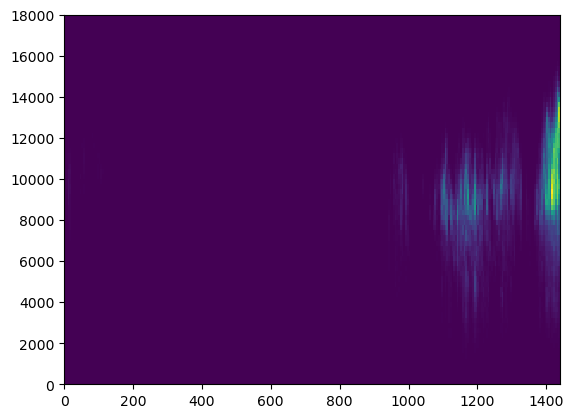

In [10]:
min_mesh, z_mesh = np.meshgrid(min_bins, z_bins)
fig,ax=plt.subplots(1,1)
ax.pcolormesh(min_mesh, z_mesh, src_th_histo.T)

In [11]:
def hourly_flash_rate(ds):
    if ds.flash_init_x.shape[0] < 1:
        return None
    flash_r = np.sqrt(ds.flash_init_x*ds.flash_init_x + ds.flash_init_y*ds.flash_init_y)
    good_flashes = (ds.flash_event_count > 5) & (flash_r < 150e3)
    flashes = ds.flash_time_start[{'number_of_flashes':good_flashes}]
    if flashes.shape[0] < 1:
        return None
    flashes['hour_floor'] = flashes.flash_time_start.dt.floor('H')
    hour_counts = flashes.groupby('hour_floor').count()
    return hour_counts

In [12]:
def separate_dims(ds):
    dims = ds.dims.keys()
    grid_dims = [dim for dim in dims if 'grid' in dim]
    other_dims = [dim for dim in dims if 'grid' not in dim]
    flash_ds = ds.drop_dims(grid_dims)
    grid_ds = ds.drop_dims(other_dims)
    return flash_ds, grid_ds

def sum_one_ds(ds):
    flash_ds, grid_ds = separate_dims(ds)
    fed_sum = grid_ds.flash_extent_density.sum(dim='grid_time')
    return fed_sum

In [13]:
fed_sum = sum_one_ds(sample_ds)
fed_sum

<xarray.DataArray 'flash_extent_density' (grid_y: 1001, grid_x: 1001)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * grid_x   (grid_x) float64 -2.5e+05 -2.495e+05 ... 2.495e+05 2.5e+05
  * grid_y   (grid_y) float64 -2.5e+05 -2.495e+05 ... 2.495e+05 2.5e+05

In [14]:
def agg_lma_from_filenames(lma_files):
    fed_sum = None
    rates = []
    for lma_file in lma_files:
        with xr.open_dataset(lma_file) as ds:
            fed = sum_one_ds(ds)
            rates.append(hourly_flash_rate(ds))
            if fed_sum is None:
                fed_sum = fed
            else:
                fed_sum += fed
    return fed_sum, rates

def agg_rates_from_filenames(lma_files):
    rates = []
    for lma_file in lma_files:
        with xr.open_dataset(lma_file) as ds:
            these_rates = hourly_flash_rate(ds) 
            if these_rates is not None:
                rates.append(these_rates)
    return rates


def agg_time_height_from_filenames(lma_files):
    rates = []
    for lma_file in lma_files:
        with xr.open_dataset(lma_file) as ds:
            these_rates = source_time_height_density(ds) 
            if these_rates is not None:
                rates.append(these_rates)
    return rates


# Calculate

- sum for each of Jun-Sep
- sum for all
- hourly flash rate
- NOTYET flash rate above La Porte


## Time series

In [19]:
june_rates = agg_rates_from_filenames(june_lma_files)
july_rates = agg_rates_from_filenames(july_lma_files)
august_rates = agg_rates_from_filenames(august_lma_files)
september_rates = agg_rates_from_filenames(september_lma_files)

In [20]:
june_th_srcs = agg_time_height_from_filenames(june_lma_files)
july_th_srcs = agg_time_height_from_filenames(july_lma_files)
august_th_srcs = agg_time_height_from_filenames(august_lma_files)
september_th_srcs = agg_time_height_from_filenames(september_lma_files)

In [21]:
# Get the first day's time height grid coordinate data
th_grid_minutes_edge = september_th_srcs[0][1]/60
th_grid_altitudes_edge = september_th_srcs[0][2]/1000.0
th_grid_minutes_ctr = (th_grid_minutes_edge[1:]+th_grid_minutes_edge[:-1])/2
th_grid_altitudes_ctr = (th_grid_altitudes_edge[1:]+th_grid_altitudes_edge[:-1])/2

In [22]:
all_june_hours = np.arange(np.datetime64('2022-06-01 00:00:00'),
                           np.datetime64('2022-07-01 00:00:00'),
                           np.timedelta64(1, 'h'))
# Concatenate what we have and fill in missing hours with nan
june_rate_series = xr.concat(june_rates, dim='hour_floor').reindex({"hour_floor":all_june_hours})
june_th_series = xr.DataArray(np.sum([t[0] for t in june_th_srcs], axis=0), 
                              coords=[('Hour of Day', th_grid_minutes_ctr), 
                                      ('Altitude (m)', th_grid_altitudes_ctr)])

In [23]:
all_july_hours = np.arange(np.datetime64('2022-07-01 00:00:00'),
                           np.datetime64('2022-08-01 00:00:00'),
                           np.timedelta64(1, 'h'))
# Concatenate what we have and fill in missing hours with nan
july_rate_series = xr.concat(july_rates, dim='hour_floor').reindex({"hour_floor":all_july_hours})
july_th_series = xr.DataArray(np.sum([t[0] for t in july_th_srcs], axis=0), 
                              coords=[('Hour of Day', th_grid_minutes_ctr), 
                                      ('Altitude (m)', th_grid_altitudes_ctr)])

In [24]:
all_august_hours = np.arange(np.datetime64('2022-08-01 00:00:00'),
                           np.datetime64('2022-09-01 00:00:00'),
                           np.timedelta64(1, 'h'))
# Concatenate what we have and fill in missing hours with nan
august_rate_series = xr.concat(august_rates, dim='hour_floor').reindex({"hour_floor":all_august_hours})
august_th_series = xr.DataArray(np.sum([t[0] for t in august_th_srcs], axis=0), 
                              coords=[('Hour of Day', th_grid_minutes_ctr), 
                                      ('Altitude (m)', th_grid_altitudes_ctr)])

In [25]:
all_september_hours = np.arange(np.datetime64('2022-09-01 00:00:00'),
                           np.datetime64('2022-10-01 00:00:00'),
                           np.timedelta64(1, 'h'))
# Concatenate what we have and fill in missing hours with nan
september_rate_series = xr.concat(september_rates, dim='hour_floor').reindex({"hour_floor":all_september_hours})
september_th_series = xr.DataArray(np.sum([t[0] for t in september_th_srcs], axis=0), 
                              coords=[('Hour of Day', th_grid_minutes_ctr), 
                                      ('Altitude (m)', th_grid_altitudes_ctr)])

In [26]:
import matplotlib.dates as mdates

def plot_rates(rate_series, title, log=False):
    fig, ax = plt.subplots(1,1, figsize=(8,3))
    if log:
        ax.semilogy(rate_series.hour_floor, rate_series.values)
        ax.set_ylim(1, 1e6)
    else:
        ax.plot(rate_series.hour_floor, rate_series.values)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')
    ax.set_title(title)
    fig.tight_layout()

In [28]:
# plot_rates(june_rate_series, title="June Hourly Flash Rate", log=True)
# plt.savefig("Jun2022-Houston-HourlyFlashRate.pdf")
# plot_rates(july_rate_series, title="July Hourly Flash Rate", log=True)
# plt.savefig("Jul2022-Houston-HourlyFlashRate.pdf")
# plot_rates(august_rate_series, title="August Hourly Flash Rate", log=True)
# plt.savefig("Aug2022-Houston-HourlyFlashRate.pdf")
# plot_rates(september_rate_series, title="September Hourly Flash Rate", log=True)
# plt.savefig("Sep2022-Houston-HourlyFlashRate.pdf")

In [29]:
from matplotlib.colors import Normalize, LogNorm
from matplotlib.ticker import MultipleLocator

def plot_time_height_density(th_grid, title, log=False):
    fig, ax = plt.subplots(1,1, figsize=(8,3))
    if log:
        norm=LogNorm(vmin=1, vmax=1e4)
    else:
        norm=Normalize(vmin=1, vmax=1e4)
    th_grid.plot.imshow(norm=norm, ax=ax, zorder=0, cbar_kwargs={'pad': 0.1})
    twinx = ax.twinx()
    twinx.set_ylabel("Column total")
    th_grid.sum(axis=0).plot(ax=twinx, color='k', zorder=99)
    ax.xaxis.set_major_locator(MultipleLocator(3))
    # ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    # for label in ax.get_xticklabels(which='major'):
        # label.set(rotation=30, horizontalalignment='right')
    ax.set_title(title)
    fig.tight_layout(h_pad=1.5)

In [30]:
# plot_time_height_density(june_th_series.T, title="June Source Count", log=True)
# plt.savefig('Jun2022-Houston-src_timeheight.pdf')
# plot_time_height_density(july_th_series.T, title="July Source Count", log=True)
# plt.savefig('Jul2022-Houston-src_timeheight.pdf')
# plot_time_height_density(august_th_series.T, title="August Source Count", log=True)
# plt.savefig('Aug2022-Houston-src_timeheight.pdf')
# plot_time_height_density(september_th_series.T, title="September Source Count", log=True)
# plt.savefig('Sep2022-Houston-src_timeheight.pdf')

In [31]:
print(june_rate_series.sum())
print(july_rate_series.sum())
print(august_rate_series.sum())
print(september_rate_series.sum())

<xarray.DataArray 'flash_time_start' ()>
array(50782.)
<xarray.DataArray 'flash_time_start' ()>
array(169297.)
<xarray.DataArray 'flash_time_start' ()>
array(289920.)
<xarray.DataArray 'flash_time_start' ()>
array(113451.)


In [32]:
50782+169297+289920+113451

623450

## Plan view

In [13]:
june_fed_sum = agg_lma_from_filenames(june_lma_files)

In [14]:
july_fed_sum = agg_lma_from_filenames(july_lma_files)

In [15]:
august_fed_sum = agg_lma_from_filenames(august_lma_files)

In [10]:
september_fed_sum = agg_lma_from_filenames(september_lma_files)

In [11]:
from matplotlib.colors import LogNorm
fed_norm = LogNorm(vmin=1, vmax=400)

In [12]:
from cartopy.geodesic import Geodesic
import shapely.geometry as sgeom

def range_ring(radius, crs):
    gd = Geodesic()
    cp = gd.circle(lon=crs.proj4_params['lon_0'],
                   lat=crs.proj4_params['lat_0'], radius=radius)
    return sgeom.Polygon(cp)

def plot_grid_map(grid, title=""):
    fig = plt.figure()

    
    p = grid.plot.imshow(norm=fed_norm, transform=crs, subplot_kws={"projection": crs})
    p.axes.coastlines()
    p.axes.set_title(title)

    geoms = [range_ring(r, crs) for r in [50e3, 100e3, 150e3, 200e3, 250e3]]
    p.axes.add_geometries(geoms, crs=ccrs.PlateCarree(), linewidth=0.5,
                          edgecolor='r', facecolor='none', alpha=0.5)

In [13]:
plot_grid_map(june_fed_sum[0], title="June 2022")
plt.savefig("Jun2022-Houston-FED.pdf")

NameError: name 'june_fed_sum' is not defined

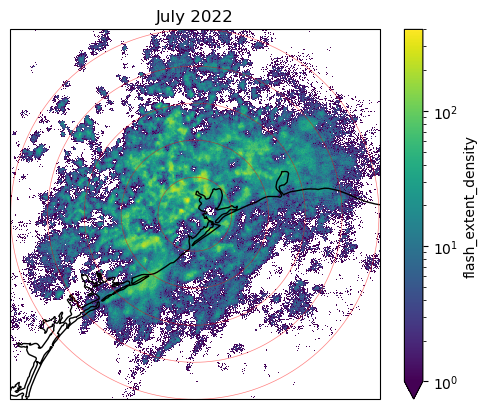

In [20]:
plot_grid_map(july_fed_sum[0], title="July 2022")
plt.savefig("Jul2022-Houston-FED.pdf")

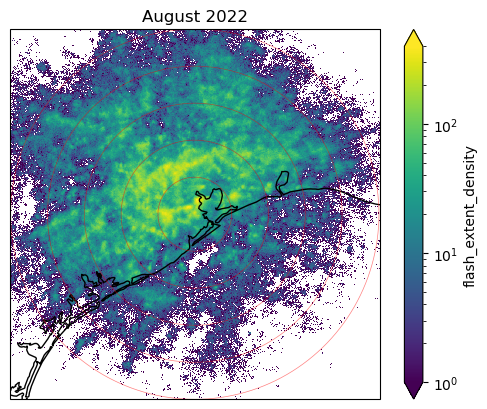

In [21]:
plot_grid_map(august_fed_sum[0], title="August 2022")
plt.savefig("Aug2022-Houston-FED.pdf")

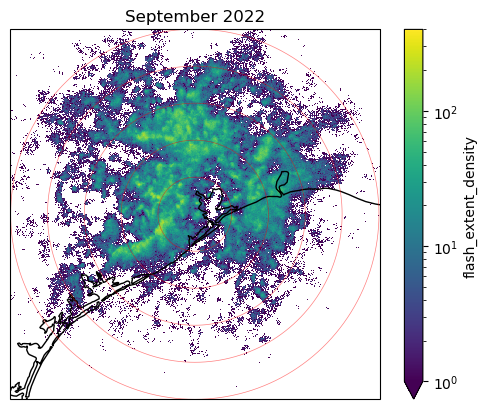

In [14]:
plot_grid_map(september_fed_sum[0], title="September 2022")
plt.savefig("Sep2022-Houston-FED.pdf")

In [23]:
june_fed_sum[0].max()

<xarray.DataArray 'flash_extent_density' ()>
array(197.)

In [24]:
july_fed_sum[0].max()

<xarray.DataArray 'flash_extent_density' ()>
array(371.)

In [25]:
august_fed_sum[0].max()

<xarray.DataArray 'flash_extent_density' ()>
array(437.)

In [26]:
september_fed_sum[0].max()

<xarray.DataArray 'flash_extent_density' ()>
array(165.)

## Find the offset between these center of these grids and csapr

In [ ]:
lma_grid_ctr_lat, lma_grid_ctr_lon

In [ ]:
print(sample_ds.lon[500,500].data)
print(sample_ds.lat[500,500].data)

In [ ]:
sample_ds.grid_x[1]-sample_ds.grid_x[0]

In [ ]:
csapr_center_lat, csapr_center_lon  =  29.531687, -95.283879

In [ ]:
sample_ds.lon

In [ ]:
csapr_dlon = (sample_ds.lon-csapr_center_lon)
csapr_dlat = (sample_ds.lat-csapr_center_lat)

# Index of the smallest squared distance is also the index of the smallest distance
csapr_idx = ((csapr_dlon*csapr_dlon + csapr_dlat*csapr_dlat)).argmin(dim=['grid_y', 'grid_x'])
# csapr_lat_1d_idx = ((sample_ds.lat-csapr_center_lat).map_blocks(np.fabs)).argmin(dim=['grid_y', 'grid_x'])


In [ ]:
# csapr offset in m
sample_ds[csapr_idx][['grid_x', 'grid_y']]
# x = -20 km, y= 6.5 km

In [ ]:
np.abs((sample_ds.lon-csapr_center_lon)).ar